# Overview

In this notebook, we are applying the concept of [Hierarical Temporal Memory](https://en.wikipedia.org/wiki/Hierarchical_temporal_memory), in order to detect an anomaly in the cpu_usage data extracted from the operate first smaug cluster. The data is extracted with the help of [data collection](https://github.com/aicoe-aiops/HTM-applications/blob/master/notebooks/data-collection.ipynb) notebook. The extracted data is then converted into the csv file and analysed in this notebook. For simplicity, we have taken cpu_usage data at 5 mins interval. The reference for the code in this notebook are taken from [hotgym](https://github.com/htm-community/htm.core/blob/master/py/htm/examples/hotgym.py) code from the [htm.core](https://github.com/htm-community/htm.core) community fork.

The real strength of HTM lies in pattern recognition. Using the cpu_usage value and timestamps, it trains a simple model to predict the next likely cpu_usage value and detect anomalpus activity. Its an elegant way of showing how HTM deals with patterns, and there is a huge amount of industry applications for time series and anomaly detection.

The whole process of anomaly detection have following steps: 

1. Getting data from .csv file.
2. Create Encoder 
3. Create Spatial Pooler
4. Create Temporal Memory
5. Training loop, prediction on each iteration
6. Based on the prediction, anamolous activity is detected. 

# Import libraries

In [123]:
import csv
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.animation import FuncAnimation # FuncAnimation is a class in matplotlib animation module
%matplotlib notebook
from IPython import display

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.bindings.algorithms import Predictor

# Default parameters

- columnDimensions : It is a sequence representing dimensions of the columns in the region. Default `2048`. 

- potentialPct : or potential percent is defining percent of inputs within a column’s potential radius, that a column can be connected to. If it has a value 1 then it means the column will be connected to all input bits within its potential radius. Default value “0.85”.

- synPermConnected : The default connected threshold. Any synapse whose permanence value is above the connected threshold is a "connected synapse", meaning it can contribute to the cell's firing. Default “0.1”.

- 

In [124]:
parameters = {
    # there are 2 (3) encoders: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
    "enc": {
        "value": {"resolution": 0.88, "size": 700, "sparsity": 0.02},
        "time": {"timeOfDay": (30, 1), "weekend": 21},
    },
    "predictor": {"sdrc_alpha": 0.1},
    "sp": {
        "boostStrength": 3.0,
        "columnCount": 1638,
        "localAreaDensity": 0.04395604395604396,
        "potentialPct": 0.85,
        "synPermActiveInc": 0.04,
        "synPermConnected": 0.13999999999999999,
        "synPermInactiveDec": 0.006,
    },
    "tm": {
        "activationThreshold": 13,
        "cellsPerColumn": 32,
        "initialPerm": 0.21,
        "maxSegmentsPerCell": 255,
        "maxSynapsesPerSegment": 255,
        "minThreshold": 10,
        "newSynapseCount": 20,
        "permanenceDec": 0.1,
        "permanenceInc": 0.1,
    },
    "anomaly": {"period": 30},
}

# Read Input File

In [125]:
df0 = pd.read_csv('../../../data_cpu/df_cpu_info.csv')
#df0 = pd.read_csv('df_cpu_info.csv')
records = df0.values.tolist()

In [126]:
records

[['2022-03-01 00:00:00', 50.3748537998054],
 ['2022-03-01 00:05:00', 50.3748537998054],
 ['2022-03-01 00:10:00', 50.3748537998054],
 ['2022-03-01 04:05:00', 48.55867699066354],
 ['2022-03-01 04:10:00', 54.04609098936573],
 ['2022-03-01 04:15:00', 46.68561881227271],
 ['2022-03-01 04:20:00', 52.57501399818778],
 ['2022-03-01 04:25:00', 47.79358990056959],
 ['2022-03-01 04:30:00', 50.21231031451045],
 ['2022-03-01 04:35:00', 48.61108625516937],
 ['2022-03-01 04:40:00', 46.10773722618944],
 ['2022-03-01 04:45:00', 47.80639150973174],
 ['2022-03-01 04:50:00', 44.793893875175165],
 ['2022-03-01 04:55:00', 44.9947189334642],
 ['2022-03-01 05:00:00', 42.53469234589135],
 ['2022-03-01 05:05:00', 41.60691200950268],
 ['2022-03-01 05:10:00', 42.62643213583843],
 ['2022-03-01 05:15:00', 42.86318183587292],
 ['2022-03-01 05:20:00', 42.640351774844206],
 ['2022-03-01 05:25:00', 43.20520612751499],
 ['2022-03-01 05:30:00', 42.124292822946174],
 ['2022-03-01 05:35:00', 43.980034384997566],
 ['2022-03

# Implementing Encoders

The distinguishing factor of HTM models are that they only work with binary inputs.Specifically, [Sparse Distributed Representations](https://github.com/aicoe-aiops/HTM-applications/blob/master/docs/HTM_intro/htm_properties.md): a bit vector of 1s and 0s. 

This is possible through any implementation of an Encoder: an object designed to take a data type (int, string, image, etc) and convert it into an SDR. A good encoder ensures that 'similar' input data created SDRs that are also similar, by way of having overlapping bits.

In [127]:
date_encoder = DateEncoder(
    timeOfDay=parameters["enc"]["time"]["timeOfDay"],
    weekend=parameters["enc"]["time"]["weekend"],
)
scalar_encoder_params = RDSE_Parameters()  # Random distributed scalar encoder
scalar_encoder_params.size = parameters["enc"]["value"]["size"]  # 700
scalar_encoder_params.sparsity = parameters["enc"]["value"]["sparsity"]  # 0.02
scalar_encoder_params.resolution = parameters["enc"]["value"]["resolution"]  # 0.88
scalar_encoder = RDSE(scalar_encoder_params)  # create an encoder

encoding_width = date_encoder.size + scalar_encoder.size
enc_info = Metrics([encoding_width], 99999999)  # performance metrics storage objects

# Spatial Pooling

The next step is spatial pooling: the part that takes the encoded input SDR and translates it to a sparse more 'balanced' SDR while maintaining spatial relationships. It is briefly explained in this [doc](https://github.com/aicoe-aiops/HTM-applications/blob/master/docs/HTM_intro/htm_properties.md). However, A good [youtube](https://www.youtube.com/watch?v=R5UoFNtv5AU) video link by Numenta is also available.

In [128]:
sp_params = parameters["sp"]
sp = SpatialPooler(
    inputDimensions=(encoding_width,),
    columnDimensions=(sp_params["columnCount"],),
    potentialPct=sp_params["potentialPct"],
    potentialRadius=encoding_width,
    globalInhibition=True,
    localAreaDensity=sp_params["localAreaDensity"],
    synPermInactiveDec=sp_params["synPermInactiveDec"],
    synPermActiveInc=sp_params["synPermActiveInc"],
    synPermConnected=sp_params["synPermConnected"],
    boostStrength=sp_params["boostStrength"],
    wrapAround=True,
)
sp_info = Metrics(sp.getColumnDimensions(), 999999999)

# Temporal pooling

Temporal Pooling enables us to understand the sequential pattern over time. It learns the sequences of the active column from the Spatial Pooler and predicts what spatial pattern in coming next based on the temporal context of each input. It has been briefly explained in this [docs](https://github.com/aicoe-aiops/HTM-applications/blob/master/docs/HTM_intro/htm_properties.md). A [youtube](https://www.youtube.com/watch?v=UBzemKcUoOk&list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9&index=13) link from Numenta is also helpful. 

In [129]:
tm_params = parameters["tm"]
tm = TemporalMemory(
    columnDimensions=(sp_params["columnCount"],),
    cellsPerColumn=tm_params["cellsPerColumn"],
    activationThreshold=tm_params["activationThreshold"],
    initialPermanence=tm_params["initialPerm"],
    connectedPermanence=sp_params["synPermConnected"],
    minThreshold=tm_params["minThreshold"],
    maxNewSynapseCount=tm_params["newSynapseCount"],
    permanenceIncrement=tm_params["permanenceInc"],
    permanenceDecrement=tm_params["permanenceDec"],
    predictedSegmentDecrement=0.0,
    maxSegmentsPerCell=tm_params["maxSegmentsPerCell"],
    maxSynapsesPerSegment=tm_params["maxSynapsesPerSegment"],
)

tm_info = Metrics([tm.numberOfCells()], 999999999)

AnomalyLikelihood()

# Training

HTM model is unsupervised, it trains and predicts as it goes. Each cpu_usage and timestamp pair is encoded, spatial pooled, temporally memorized, and used for predictions, so we will be able to see its predictions improving as it learns from each SDR. 

In [130]:
anomaly_history = AnomalyLikelihood(parameters["anomaly"]["period"])

predictor = Predictor(steps=[1, 5], alpha=parameters["predictor"]["sdrc_alpha"])
predictor_resolution = 1

# Iterate through every datum in the dataset, record the inputs & outputs.
inputs = []
anomaly = []
anomaly_prob = []
predictions = {1: [], 5: []}

for count, record in enumerate(records):
    # convert date string into Python date object:
    date_string = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
    # Convert data value string into float:
    consumption = float(record[1])
    inputs.append(consumption)

    # Call the encoders to create bit representations for each value. These are SDR objects.
    date_bits = date_encoder.encode(date_string)
    consumption_bits = scalar_encoder.encode(consumption)

    # Concatenate all these encodings into one large encoding for Spatial Pooling
    encoding = SDR(encoding_width).concatenate([consumption_bits, date_bits])
    enc_info.addData(encoding)

    # Create an SDR to represent active columns, This will be populated by the compute method below.
    # It must have the same dimensions as a Spatial Pooler.
    active_columns = SDR(sp.getColumnDimensions())

    # Execute Spatial Pooling algorithm over input space

    sp.compute(encoding, True, active_columns)
    sp_info.addData(active_columns)

    # Execute Temporal Memory algorithmover active mini-columns
    tm.compute(active_columns, learn=True)
    tm_info.addData(tm.getActiveCells().flatten())

    # Predict what will happen, and then train the predictor based on what just happened

    pdf = predictor.infer(tm.getActiveCells())
    for n in (1, 5):
        if pdf[n]:
            predictions[n].append(np.argmax(pdf[n]) * predictor_resolution)
        else:
            predictions[n].append(float("nan"))

    anomaly.append(tm.anomaly)
    anomaly_prob.append(anomaly_history.compute(tm.anomaly))

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

In [131]:
# Print information and statistics about the state of the HTM
print("Encoded Input", enc_info)
print("")
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))
print("")
print("Temporal Memory Cells", tm_info)
print(str(tm))
print("")

Encoded Input SDR( 1462 )
    Sparsity Min/Mean/Std/Max 0.0444596 / 0.0444594 / 7.09312e-07 / 0.0444596
    Activation Frequency Min/Mean/Std/Max 0 / 0.0444596 / 0.124184 / 0.966942
    Entropy 0.593603
    Overlap Min/Mean/Std/Max 0.2 / 0.924201 / 0.073779 / 0.969231

Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max 0.043956 / 0.0439559 / 3.08808e-07 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.0439561 / 0.034007 / 0.109504
    Entropy 0.888228
    Overlap Min/Mean/Std/Max 0 / 0.865811 / 0.161627 / 1
Spatial Pooler Connections:
    Inputs (1462) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1243 / 1243 / 1243
    Connected Synapses on Segment Min/Mean/Max 113 / 414.701 / 666
    Synapses Dead (0.441096%) Saturated (0.02048%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0


Temporal Memory Cells SDR

In [132]:
df0['prediction'] = predictions[1]
df0['anomaly_score'] = anomaly
df0['anomaly_likelihood'] = anomaly_prob
df0.head(20)

,time,value,prediction,anomaly_score,anomaly_likelihood
0,2022-03-01 00:00:00,50.374854,NaN,1.000000,0.030103
1,2022-03-01 00:05:00,50.374854,NaN,1.000000,0.030103
2,2022-03-01 00:10:00,50.374854,0.0,1.000000,0.030103
3,2022-03-01 04:05:00,48.558677,0.0,1.000000,0.030103
4,2022-03-01 04:10:00,54.046091,0.0,1.000000,0.030103
5,2022-03-01 04:15:00,46.685619,0.0,1.000000,0.030103
6,2022-03-01 04:20:00,52.575014,0.0,1.000000,0.030103
7,2022-03-01 04:25:00,47.793590,54.0,1.000000,0.030103
8,2022-03-01 04:30:00,50.212310,54.0,1.000000,0.030103
9,2022-03-01 04:35:00,48.611086,50.0,1.000000,0.030103


## Anomaly Likelihood

This class analyses a time series of anomaly values (as returned by thetemporal memory class) and determines the likelihood that an anomaly hasactually occurred. This class assumes that the anomaly values are part of a
normal distribution and so it tracks the mean and standard deviation of them using an exponentially weighted moving window.

# Plots 

Here, We are plotting the input signal, 1 step prediction, 5 step prediction, Instantenous anomaly and Anomaly Likelihood. Anomaly Likelihood is considered to be the best predictor of Anomaly. 

<IPython.core.display.Javascript object>


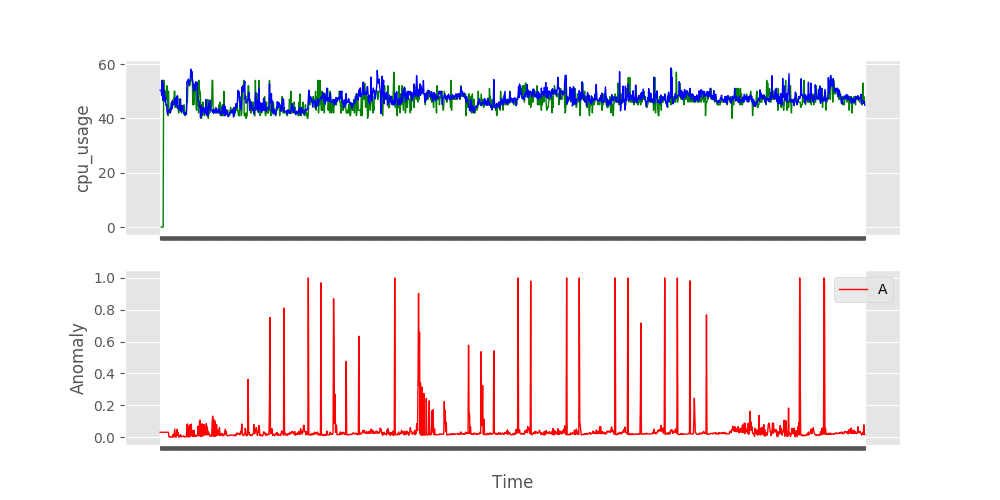

In [133]:
plt.figure(figsize=(10, 5))
data = df0
        
plt.subplot(2, 1, 1)
x = data['time']
y1 = data['prediction']
y2 = data['value']
plt.plot(x,y1, color='green', linewidth=1)
plt.plot(x,y2, color='blue', linewidth=1)
#plt.legend(labels =('Prediction', 'Input'))
#plt.legend(labels =('Input'))
plt.xticks(color='w')
plt.ylabel('cpu_usage')
    
    
plt.subplot(2, 1, 2)
x = data['time']
y1 = data['anomaly_score']
y2 = data['anomaly_likelihood']
#plt.plot(x,y1, color='green', linewidth=1)
plt.plot(x,y2, color='red', linewidth=1)
plt.legend(labels =('Anomaly Score', 'Anomaly Likelihood'))
plt.legend(labels =('Anomaly Likelihood'))
plt.xticks(color='w')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.show()

<IPython.core.display.Javascript object>


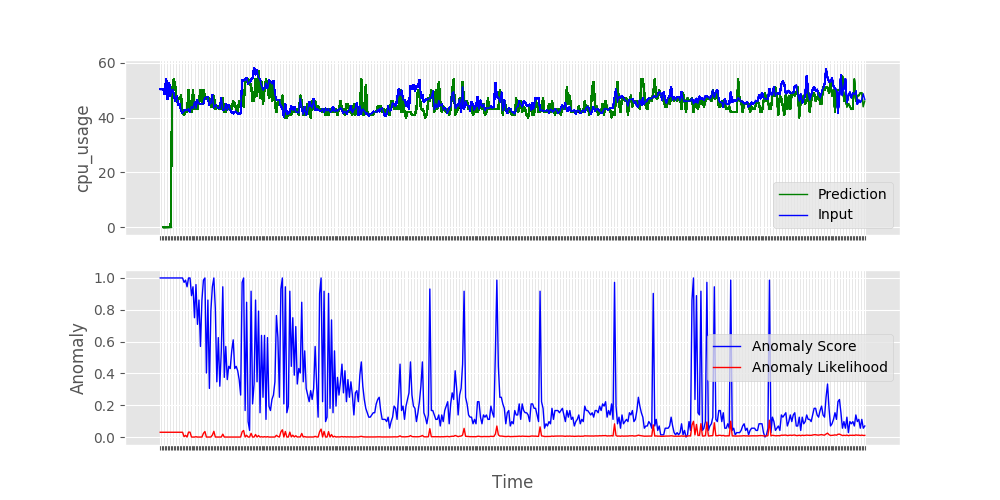

In [134]:
y1 = []
y2 = []
x = []

plt.figure(figsize=(10, 5))
def animate(i):
    data = df0
    plt.cla() #clear axis
        
    plt.subplot(2, 1, 1)
    x = data['time'].iloc[0:i]
    y1 = data['prediction'].iloc[0:i]
    y2 = data['value'].iloc[0:i]
    plt.plot(x,y1, color='green', linewidth=1)
    plt.plot(x,y2, color='blue', linewidth=1)
    plt.legend(labels =('Prediction', 'Input'))
    plt.xticks(color='w')
    plt.ylabel('cpu_usage')
    
   # plt.subplot(3, 1, 2)
   # x = data['time'].iloc[0:i]
   # y1 = data['prediction'].iloc[0:i]
   # y2 = data['value'].iloc[0:i]
    #plt.plot(x,y1, color='green', linewidth=1)
   # plt.plot(x,y2, color='blue', linewidth=1)
   # plt.xticks(color='w')
   # plt.ylabel('prediction')
    
    plt.subplot(2, 1, 2)
    x = data['time'].iloc[0:i]
    y1 = data['anomaly_score'].iloc[0:i]
    y2 = data['anomaly_likelihood'].iloc[0:i]
    plt.plot(x,y1, color='blue', linewidth=1)
    plt.plot(x,y2, color='red', linewidth=1)
    plt.legend(labels =('Anomaly Score', 'Anomaly Likelihood'))
    plt.xticks(color='w')
    plt.xlabel('Time')
    plt.ylabel('Anomaly')
    
ani = FuncAnimation(plt.gcf(), animate , interval=30, frames =2000,repeat=False)


#plt.tight_layout() #adds pads
#plt.figure(figsize=(10, 5))
#plt.show()

If we just plot the input signal and Anomaly likelihood side by side, in order to check if our algorithm has detected anomalies or not.

The X-axis is the timestep and y axis is the cpu_usage values over a period of 24 hours. The model does a good job of understanding minute fluctualtions (say between 200-300 time step).

# Conclusion

The following notebook used HTM algorithm to detect the anomalies for the cpu_usage data collected from the operate first cluster. So far, Anomaly likelihood does seems to be a good indicator for detecting anomalies. The instantenous anomaly seems maximum at first since, it is in the learning stage. As it learns through the data, it becomes more reasonable.

In the next steps, we will apply it to the larger dataset and look for more parameters which would help the code to be more efficient. 